In [1]:
from pathlib import Path
import string

import numpy as np
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

import gm

from ak_diseq.glacierData import glacierData
from ak_diseq.utils import hist2, weighted_quantile

plt.style.use('default')
# todo: add total iterations to tqdm
gd = glacierData()
len(gd.rgi)

5205

In [2]:
gd = glacierData()
gd.calc_response_time()
gd.calc_linear_feq()
d = gd.rgi
print(len(d))

5179


/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_52428/3783371675.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  be = be.fillna(method='bfill')


,linear,gwi,pwl,be_ak,be_ak_uf
1880,0.008511,0.008511,0.008511,0.000000,NaN
1881,0.017021,0.010175,0.014202,-0.016936,-0.118400
1882,0.025532,0.011840,0.019894,-0.032640,-0.357667
1883,0.034043,0.013504,0.025585,-0.047066,0.192083
1884,0.042553,0.015169,0.031277,-0.060182,-0.233250
...,...,...,...,...,...
2016,1.165957,1.123636,1.116364,1.083285,2.875000
2017,1.174468,1.142727,1.137273,1.080511,2.337667
2018,1.182979,1.161818,1.158182,1.076136,3.111750
2019,1.191489,1.180909,1.179091,1.070497,2.930917


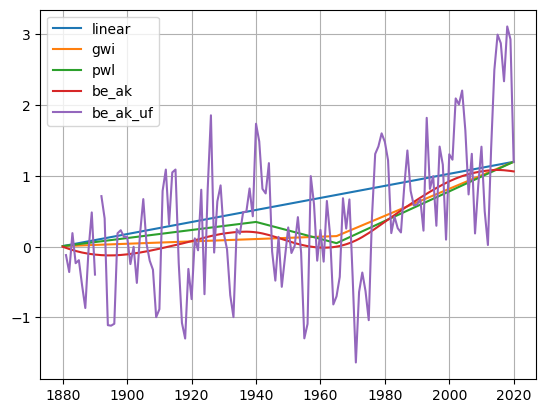

In [3]:
idx = np.arange(1880, 2021, 1)
df = pd.DataFrame([], index=idx)

# linear trend
df['linear'] = np.linspace(0, 1.2, 142)[1:]

# Synthetic GWI
ts1 = np.linspace(df.linear.iloc[0], 0.15, 86)[:-1]
ts2 = np.linspace(0.15, df.linear.iloc[-1], 56)
df['gwi'] = np.concatenate([ts1, ts2])

# follow linear trend at start
ts1 = np.linspace(df.linear.iloc[0], 0.35, 61)[:-1]
ts2 = np.linspace(0.35, 0.05, 26)[:-1]
ts3 = np.linspace(0.05, df.linear.iloc[-1], 56)

df['pwl'] = np.concatenate([ts1, ts2, ts3])

# berk earth AK-avg temp
fp = Path(r'~/src/USGS/glacier_data/berkeley_earth/alaska-TAVG-Trend_clean.csv')
be = pd.read_csv(fp)
be = be.groupby('year').mean()
be = be['annual']
be_uf = be.copy()
be = be.fillna(method='bfill')
sos = sci.signal.butter(2, 1/30, btype='lowpass', output='sos')  # units are half-cycles/sample, so 1/15 = 1 cycle per 30 yrs.
be = pd.Series(sci.signal.sosfiltfilt(sos, be), index=be.index)
be = be.loc[1880:]
be = (be - be.iloc[0])/df['linear'].iloc[-1]
df['be_ak'] = be
df['be_ak_uf'] = be_uf




fig, ax = plt.subplots(1,1)
df.plot(ax=ax)
ax.legend()
ax.grid()

df

# Figure 8

In [4]:

rescol = 'pwl'
melt_factor = -0.65
b_p = df
b_p = b_p * melt_factor

concat = []
for i, (_, g) in tqdm(enumerate(d.iterrows())):
    tau = g['tau']
    params_3s = dict(
        dt=0.01,
        Atot=g['Area'],
        W=g['Area']/g['Lmax'],
        L=g['Lmax'],
        H=g['hf'],
        bt=0,
        b_p=b_p[rescol].values,
        ts=df.index.to_numpy(),
    )
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res = res.iloc[[-1]]
    res['tau'] = tau
    res['RGIId'] = g['RGIId']
    res['name'] = g['Name']
    res['etcw_feq'] = res.Lp / (res.Lp_eq)
    concat.append(res)
concat = pd.concat(concat, ignore_index=True)
d = d.merge(concat.loc[:, ['RGIId', 'etcw_feq']], on='RGIId')

5179it [00:04, 1217.58it/s]


In [5]:
rescol = 'gwi'

melt_factor = -0.65
b_p = df
b_p = b_p * melt_factor

concat = []
for i, (_, g) in tqdm(enumerate(d.iterrows())):
    tau = g['tau']
    params_3s = dict(
        dt=0.01,
        Atot=g['Area'],
        L=g['Lmax'],
        H=g['hf'],
        bt=0,
        b_p=b_p[rescol].values,
        ts=df.index.to_numpy(),
    )
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res = res.iloc[[-1]]
    res['tau'] = tau
    res['RGIId'] = g['RGIId']
    res['name'] = g['Name']
    res['gwi_feq'] = res.Lp / (res.Lp_eq)

    concat.append(res)
concat = pd.concat(concat, ignore_index=True)
d = d.merge(concat.loc[:, ['RGIId', 'gwi_feq']], on='RGIId')

5179it [00:03, 1412.16it/s]


In [6]:
d = d.sort_values(by='RGIId')
rescol = 'linear'
melt_factor = -0.65
b_p = df
b_p = b_p * melt_factor

concat = []
for i, (_, g) in tqdm(enumerate(d.iterrows())):
    tau = g['tau']
    params_3s = dict(
        dt=0.01,
        Atot=g['Area'],
        L=g['Lmax'],
        H=g['hf'],
        bt=0,
        b_p=b_p[rescol].values,
        ts=df.index.to_numpy(),
    )
    res = gm.gm3s(tau=tau, **params_3s).run()
    res = res.to_pandas().reset_index()
    res['tau'] = tau
    res = res.iloc[[-1]]
    res['RGIId'] = g['RGIId']
    res['name'] = g['Name']
    res['linear_feq'] = res.Lp / (res.Lp_eq)
    concat.append(res)
concat = pd.concat(concat, ignore_index=True)
d = d.merge(concat.loc[:, ['RGIId', 'linear_feq']], on='RGIId')

5179it [00:03, 1343.51it/s]


In [7]:
d

,feq,tau,bt,hh,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,...,Name,geometry,delz,Zela,abl_area,accu_area,hf,etcw_feq,gwi_feq,linear_feq
0,0.530869,38.793357,-1.354167,-27.760360,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.080000,63.376000,...,None,"POLYGON ((-146.07232 63.38348, -146.07232 63.3...",573,1800,0.6740,1.0110,52.532671,0.260202,0.239859,0.536751
1,0.805144,15.750179,-4.090860,139.098376,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.120000,63.381000,...,None,"POLYGON ((-146.14895 63.37919, -146.14881 63.3...",1044,1850,1.4724,2.2086,64.431770,0.545741,0.579037,0.807884
2,0.291413,67.667736,-2.828861,-2355.321213,RGI60-01.00006,G213756E63571N,20090703,-9999999,-146.244000,63.571000,...,None,"POLYGON ((-146.24360 63.55621, -146.24376 63.5...",2346,1600,4.1880,6.2820,191.422638,0.143542,0.104281,0.297105
3,0.473332,44.378333,-1.417976,-27.760360,RGI60-01.00009,G212400E63659N,20090703,-9999999,-147.600000,63.659000,...,None,"POLYGON ((-147.61465 63.66439, -147.61477 63.6...",764,1950,0.6068,0.9102,62.927392,0.229633,0.200124,0.479479
4,0.705160,23.854601,-2.091514,-21.684763,RGI60-01.00011,G213364E63349N,20090703,-9999999,-146.636000,63.349000,...,None,"POLYGON ((-146.62628 63.35467, -146.62693 63.3...",592,1650,0.4916,0.7374,49.892230,0.395347,0.415379,0.709274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5174,0.140291,106.221321,-3.956152,21.045348,RGI60-01.27101,G216527E60710N,20100919,-9999999,-143.473236,60.709583,...,North Fork Lobe Bremner Glacier,"POLYGON ((-143.31165 60.92172, -143.30992 60.9...",2690,1050,32.0876,48.1314,420.227674,0.072130,0.044948,0.143959
5175,0.224376,80.752581,-5.863329,-27.547050,RGI60-01.27103,G225914E58943N,20050811,-9999999,-134.086000,58.943000,...,None,"POLYGON ((-134.02743 59.06920, -134.02736 59.0...",1363,1700,34.6624,51.9936,473.478946,0.112332,0.076322,0.229369
5176,0.175571,93.690832,-4.558791,-38.321448,RGI60-01.27105,G227608E57164N,20040810,-9999999,-132.392000,57.164000,...,None,"POLYGON ((-132.27246 57.15952, -132.27119 57.1...",2330,1150,52.6296,78.9444,427.116965,0.089185,0.057667,0.179858
5177,0.690760,25.031482,-2.970659,-24.636225,RGI60-01.27106,G220930E60344N,20100814,-9999999,-139.070000,60.344000,...,None,"POLYGON ((-139.07132 60.32938, -139.07199 60.3...",943,3900,1.1032,1.6548,74.359991,0.379703,0.396371,0.695060


0.5789663150899295
0.28547064391996696
0.27371235184748655
0.41272088318884176
0.19704508362423928
0.1606207815500468
[Text(0, -0.2, '−0.2'), Text(0, 0.0, ''), Text(0, 0.2, '0.2'), Text(0, 0.4000000000000001, '0.4'), Text(0, 0.6000000000000001, '0.6'), Text(0, 0.8, '0.8'), Text(0, 1.0000000000000002, '1.0'), Text(0, 1.2000000000000002, '1.2')]
[Text(0, -0.2, '−0.2'), Text(0, 0.0, ''), Text(0, 0.2, '0.2'), Text(0, 0.4000000000000001, '0.4'), Text(0, 0.6000000000000001, '0.6'), Text(0, 0.8, '0.8'), Text(0, 1.0000000000000002, '1.0'), Text(0, 1.2000000000000002, '1.2')]


/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_52428/1052994396.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(labels)
/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_52428/1052994396.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(labels)


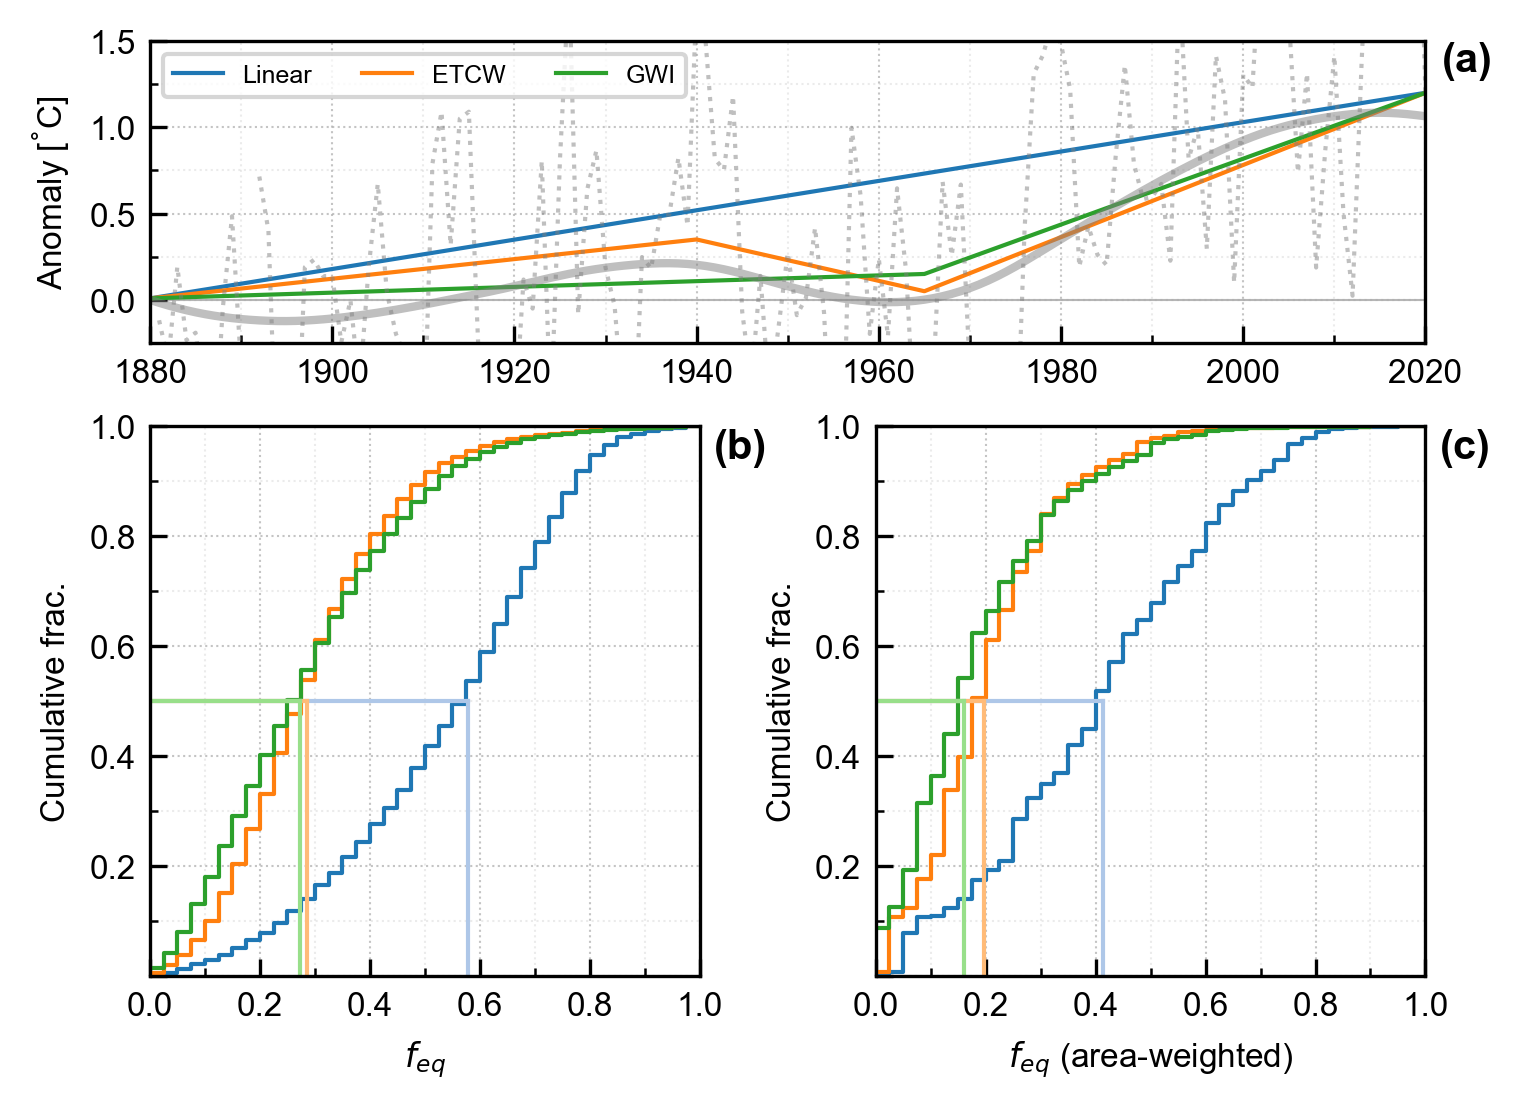

In [8]:
plt.style.use("default")

XXSMALL_SIZE = 6
XSMALL_SIZE = 8
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)  # contr
plt.rc('font', family="sans-serif")  # controls default font face
plt.rcParams["font.sans-serif"] = ['Arial']
plt.rc('axes', titlesize=XSMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=XSMALL_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=XSMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=XSMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", grid=True)
plt.rc('axes.grid', which="both", axis='both')
plt.rc('grid', linestyle=':', lw=0.5, alpha=0.75)
plt.rc("lines", lw=1)
plt.rc("figure.constrained_layout", w_pad=0)
plt.rc("figure.constrained_layout", h_pad=0)

binfreq = 0.025
x = d.dropna(subset='etcw_feq')['etcw_feq']
area = d.dropna(subset='etcw_feq')['Area']
nleq_uwpdf, nleq_bins = hist2(x, binfreq=binfreq, from_zero=True)
nleq_awpdf, nleq_bins = hist2(x, area=area, binfreq=binfreq, from_zero=True)
nleq_uwcdf, nleq_bins = hist2(x, binfreq=binfreq, cumsum=True, from_zero=True)
nleq_awcdf, nleq_bins = hist2(x, area=area, binfreq=binfreq, cumsum=True, from_zero=True)

x = d.dropna(subset='linear_feq')['linear_feq']
area = d.dropna(subset='linear_feq')['Area']
eq_uwpdf, eq_bins = hist2(x, binfreq=binfreq, from_zero=True)
eq_awpdf, eq_bins = hist2(x, area=area, binfreq=binfreq, from_zero=True)
eq_uwcdf, eq_bins = hist2(x, binfreq=binfreq, cumsum=True, from_zero=True)
eq_awcdf, eq_bins = hist2(x, area=area, binfreq=binfreq, cumsum=True, from_zero=True)

x = d.dropna(subset='gwi_feq')['gwi_feq']
area = d.dropna(subset='gwi_feq')['Area']
gwi_uwpdf, gwi_bins = hist2(x, binfreq=binfreq, from_zero=True)
gwi_awpdf, gwi_bins = hist2(x, area=area, binfreq=binfreq, from_zero=True)
gwi_uwcdf, gwi_bins = hist2(x, binfreq=binfreq, cumsum=True, from_zero=True)
gwi_awcdf, gwi_bins = hist2(x, area=area, binfreq=binfreq, cumsum=True, from_zero=True)


fig = plt.figure(figsize=(4.875, 3.5), dpi=300, layout='constrained')
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 2], figure=fig, hspace=0.02, wspace=0)
ax = [
    fig.add_subplot(gs[0, :]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
]

ax[0].plot(df.linear, label='Linear')
ax[0].plot(df.pwl, label='ETCW')
ax[0].plot(df.gwi, label='GWI')
ax[0].plot(df['be_ak'], color='grey', alpha=0.5, lw=2)
ax[0].plot(df['be_ak_uf'], color='grey', alpha=0.5, lw=1, ls=':')
ax[0].axhline(0, lw=0.5, alpha=1, c="#B6B6B6", zorder=0)

ax[1].step(eq_bins, eq_uwcdf)
ax[1].step(nleq_bins, nleq_uwcdf)
ax[1].step(gwi_bins, gwi_uwcdf)

ax[2].step(eq_bins, eq_awcdf)
ax[2].step(nleq_bins, nleq_awcdf)
ax[2].step(gwi_bins, gwi_awcdf)

# median lines

xmax = np.median(d['linear_feq'].dropna())
print(xmax)
ax[1].plot([xmax, xmax], [0, 0.5],  ls='-', c=plt.cm.tab20(1), lw=1, alpha=1)
ax[1].plot([0, xmax], [0.5, 0.5], lw=1, c=plt.cm.tab20(1))

xmax = np.median(d['etcw_feq'].dropna())
print(xmax)
ax[1].plot([xmax, xmax], [0, 0.5],  ls='-', c=plt.cm.tab20(3), lw=1, alpha=1)
ax[1].plot([0, xmax], [0.5, 0.5], lw=1, c=plt.cm.tab20(3))

xmax = np.median(d['gwi_feq'].dropna())
print(xmax)
ax[1].plot([xmax, xmax], [0, 0.5], ls='-', c=plt.cm.tab20(5), lw=1, alpha=1)
ax[1].plot([0, xmax], [0.5, 0.5], lw=1, c=plt.cm.tab20(5))





area = d['Area'].to_numpy()
x = weighted_quantile(d['linear_feq'].to_numpy(), [0.5], sample_weight=area)[0]
print(x)
ax[2].plot([x,x], [0, 0.5], ls='-', c=plt.cm.tab20(1), lw=1)
ax[2].plot([0, x], [0.5, 0.5], lw=1, c=plt.cm.tab20(1))

x = weighted_quantile(d['etcw_feq'].to_numpy(), [0.5], sample_weight=area)[0]
print(x)
ax[2].plot([x,x], [0, 0.5], ls='-', c=plt.cm.tab20(3), lw=1)
ax[2].plot([0, x], [0.5, 0.5], lw=1, c=plt.cm.tab20(3))

x = weighted_quantile(d['gwi_feq'].to_numpy(), [0.5], sample_weight=area)[0]
print(x)
ax[2].plot([x,x], [0, 0.5], ls='-', c=plt.cm.tab20(5), lw=1)
ax[2].plot([0, x], [0.5, 0.5], lw=1, c=plt.cm.tab20(5))



ax[0].legend(fontsize=XXSMALL_SIZE, ncol=3)
for axis in ax:
    axis.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
    axis.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    axis.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
    axis.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    axis.grid(which='minor', axis='both', alpha=0.25)
    axis.set_axisbelow(True)    
    axis.tick_params(axis="both", which='both', direction="in", left="off", labelleft="on", length=2, labelsize=XSMALL_SIZE)
    axis.tick_params(axis='both', which='major', length=4, labelsize=XSMALL_SIZE)
    axis.set_ylim([0, 1.00])
    axis.set_xlim(0, 1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)
#ax[0].set_xlabel('Year', fontsize=XSMALL_SIZE)
ax[1].set_xlabel(r'$f_{eq}$', fontsize=XSMALL_SIZE)
ax[2].set_xlabel(r'$f_{eq}$ (area-weighted)', fontsize=XSMALL_SIZE)
ax[0].set_ylabel('Anomaly [$^\degree$C]', fontsize=XSMALL_SIZE)
ax[1].set_ylabel('Cumulative frac.', fontsize=XSMALL_SIZE)
ax[2].set_ylabel('Cumulative frac.', fontsize=XSMALL_SIZE)
ax[0].set_ylim(-0.25, 1.5)
ax[0].set_xlim(1880, 2020)
ax[0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

# label subplots
sp_labels = ['(' + letter + ')' for letter in string.ascii_lowercase]
for i, axis in enumerate(ax[1:]):
    i = i + 1  # top ax is 0
    # label physical distance in and down:
    trans = mpl.transforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    axis.text(0.95, 1.035, sp_labels[i], transform=axis.transAxes + trans,
              verticalalignment='top', fontsize=SMALL_SIZE, fontweight='bold')
ax[0].text(0.98, 1.07, sp_labels[0], transform=ax[0].transAxes + trans,
          verticalalignment='top', fontsize=SMALL_SIZE, fontweight='bold')

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.0)

# Important to render initial ytick labels
fig.canvas.draw()

# remove bottom ylabel
for axis in ax[1:]:
    labels = [item for item in axis.get_yticklabels()]
    labels[1].set_text('')
    print(labels)
    axis.set_yticklabels(labels)

plt.savefig(Path('Fig8.svg'), bbox_inches='tight')
plt.savefig(Path('Fig8.png'), bbox_inches='tight')
plt.savefig(Path('Fig8.pdf'),bbox_inches='tight')

# Figure 9

In [9]:
# linear diseq
# disequilibrium 3-stage
def calc_diseq(tau):
    eps = 1 / np.sqrt(3)
    t = 140
    frac_eq = 1 - 3 * eps * tau / t * (1 - np.exp(-t / (eps * tau))) + np.exp(-t / (eps * tau)) * (
                t / (2 * eps * tau) + 2)
    return frac_eq


rescol = 'pwl'
melt_factor = -0.65
b_p = df * melt_factor

taus = list(np.arange(1, 500, 1))
concat = []
params_3s = dict(
    Atot=8000,
    W=1,
    L=8000,
    H=100,
    bt=0,
    b_p=b_p[rescol].to_numpy(),
    ts=df.index.to_numpy(),
)
for tau in tqdm(taus):
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res['tau'] = tau
    concat.append(res)
curve = pd.concat(concat, ignore_index=True)
curve = curve.loc[curve.t == 2020, :]


rescol = 'gwi'
melt_factor = -0.65
b_p = df * melt_factor
taus = list(np.arange(1, 500, 1))
concat = []
params_3s = dict(
    Atot=8000,
    W=1,
    L=8000,
    H=100,
    bt=0,
    b_p=b_p[rescol].to_numpy(),
    ts=df.index.to_numpy(),
)
for tau in tqdm(taus):
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res['tau'] = tau
    concat.append(res)
gwi_curve = pd.concat(concat, ignore_index=True)
gwi_curve = gwi_curve.loc[gwi_curve.t == 2020, :]


rescol = 'linear'
melt_factor = -0.65
b_p = df * melt_factor
taus = list(np.arange(1, 500, 1))
concat = []
params_3s = dict(
    Atot=8000,
    W=1,
    L=8000,
    H=100,
    bt=0,
    b_p=b_p[rescol].to_numpy(),
    ts=df.index.to_numpy(),
)
for tau in tqdm(taus):
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res['tau'] = tau
    concat.append(res)
linear_curve = pd.concat(concat, ignore_index=True)
linear_curve = linear_curve.loc[linear_curve.t == 2020, :]

curve['etcw_feq'] = curve.Lp / (curve.Lp_eq)
curve['linear_feq'] = linear_curve.Lp / (linear_curve.Lp_eq)
curve['gwi_feq'] = gwi_curve.Lp / (gwi_curve.Lp_eq)
curve = curve.reset_index(drop=True)

curve

100%|██████████| 499/499 [00:00<00:00, 5043.77it/s]


,t,Lp,Lp_eq,dL,L,bt_p,L_bar,tau,etcw_feq,linear_feq,gwi_feq
0,2020.0,-60.516506,-62.4,62.4,7939.483494,-0.78,8000,1,0.969816,0.987716,0.972442
1,2020.0,-117.267154,-124.8,124.8,7882.732846,-0.78,8000,2,0.939641,0.975432,0.944889
2,2020.0,-170.251096,-187.2,187.2,7829.748904,-0.78,8000,3,0.909461,0.963148,0.917334
3,2020.0,-219.468614,-249.6,249.6,7780.531386,-0.78,8000,4,0.879281,0.950864,0.889779
4,2020.0,-264.919711,-312.0,312.0,7735.080289,-0.78,8000,5,0.849102,0.938580,0.862223
...,...,...,...,...,...,...,...,...,...,...,...
494,2020.0,-60.355511,-30888.0,30888.0,7939.644489,-0.78,8000,495,0.001954,0.003611,0.000974
495,2020.0,-60.148929,-30950.4,30950.4,7939.851071,-0.78,8000,496,0.001943,0.003591,0.000968
496,2020.0,-59.943397,-31012.8,31012.8,7940.056603,-0.78,8000,497,0.001933,0.003572,0.000963
497,2020.0,-59.738908,-31075.2,31075.2,7940.261092,-0.78,8000,498,0.001922,0.003552,0.000958


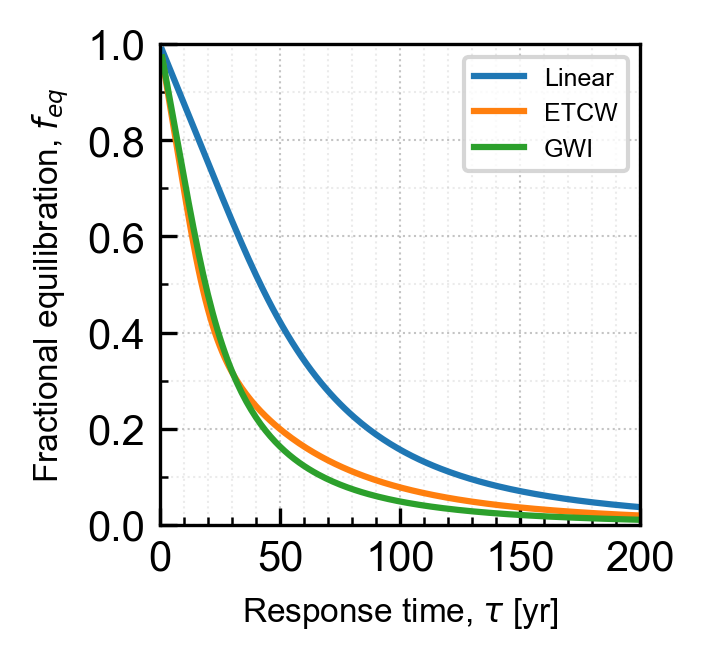

In [10]:
dir(plt.cm)
XSMALL_SIZE = 8
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)  # contr
plt.rc('font', family="sans-serif")  # controls default font face
plt.rcParams["font.sans-serif"] = ['Arial']
plt.rc('axes', titlesize=XSMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=XSMALL_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=XSMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=XSMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", grid=True)
plt.rc('axes.grid', which="both", axis='both')
plt.rc('grid', linestyle=':', lw=0.5, alpha=0.75)
plt.rc("lines", lw=1.5)

fig, ax = plt.subplots(1,1, layout='constrained', figsize=(2.15, 2.15), dpi=300)

tau = curve['tau'].to_numpy()
lower_tau = (curve['tau']/2).to_numpy()
upper_tau = (3 * curve['tau']/2).to_numpy()

feq = curve['linear_feq'].to_numpy()
lower_linear = np.interp(lower_tau, tau, feq)
upper_linear = np.interp(upper_tau, tau, feq)
# lower_linear = np.take(feq, lower_tau, mode='clip')
# upper_linear = np.take(feq, upper_tau, mode='clip')

feq = curve['etcw_feq'].to_numpy()
lower_nonlinear = np.interp(lower_tau, tau, feq)
upper_nonlinear = np.interp(upper_tau, tau, feq)

feq = curve['gwi_feq'].to_numpy()
lower_gwi = np.interp(lower_tau, tau, feq)
upper_gwi = np.interp(upper_tau, tau, feq)

ax.plot(curve.tau, curve.linear_feq, label='Linear')
ax.plot(curve.tau, curve.etcw_feq, label='ETCW')
ax.plot(curve.tau, curve.gwi_feq, label='GWI')
ax.set_xlabel(r'Response time, $\tau$ [$\mathregular{yr}$]', fontsize=XSMALL_SIZE)
ax.set_ylabel(r'Fractional equilibration, $f_{eq}$', fontsize=XSMALL_SIZE)
ax.set_box_aspect(1)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.grid(which='minor', axis='both', alpha=0.25, lw=0.5)
ax.set_xlim(0, 200)
ax.set_ylim(0, 1)
ax.set_axisbelow(True)    
ax.tick_params(axis="both", which='both', direction="in", left="off", labelleft="on", length=2, labelsize=SMALL_SIZE)
ax.tick_params(axis='both', which='major', length=4)
ax.legend(fontsize=XXSMALL_SIZE)

plt.savefig(Path('Fig9.svg'), bbox_inches='tight')
plt.savefig(Path('Fig9.png'), bbox_inches='tight')
plt.savefig(Path('Fig9.pdf'),bbox_inches='tight')

# Table A1

In [11]:
def make_table(d, cuts):
    def print_range(dd, bin_name, weights=None):
        row = pd.Series([], name=bin_name, dtype='object')
        for col in dd.columns:
            if weights is not None:
                stats = weighted_quantile(dd[col], [0.05, 0.5, 0.95], sample_weight=weights)
            else:
                stats = dd[col].quantile([0.05, 0.5, 0.95]).to_numpy()
                
            #print(stats)
            if stats[1] < 10:
                row[col] = f"{stats[1]:.2f} ({stats[0]:.2f}, {stats[2]:.2f})"
            elif col == 'frac_eq':
                row[col] = f"{stats[1]:.0f}% ({stats[0]:.0f}, {stats[2]:.0f}%)"
            else:
                row[col] = f"{stats[1]:.0f} ({stats[0]:.0f}, {stats[2]:.0f})"   
        return row
    
    bins = pd.cut(d.Area, cuts)
    value_counts = bins.value_counts()
    table = pd.DataFrame(index=value_counts.index, columns=d.columns)
    for bin, dd in d.groupby(bins):
        table.loc[bin] = print_range(dd, bin_name=bin)
    
    # row for number of glaciers in each bin
    table.insert(0, 'Count', value_counts)
    
    # row for fraction of total area in each bin
    pct_areas = (100 * d.groupby(bins)['Area'].sum()/d['Area'].sum()).astype(int)
    pct_areas = pct_areas.apply(lambda row: f"{row:d}%")
    print(pct_areas)
    print(value_counts)
    table.insert(1, 'Bin area', pct_areas)
    
    # set table index
    cat_names = ['Small', 'Medium', 'Large', 'Mega', 'Giga']
    table.index = [f"{name} {bounds}" for name, bounds in zip(cat_names, value_counts.index)]
    
    # total row
    total_row = print_range(d, bin_name='Total')
    total_row['Count'] = len(d)
    
    # area-weighted total row
    aw_total_row = print_range(d, bin_name='Area-weighted', weights=d['Area'])
    aw_total_row['Count'] = len(d)

    # put total rows in table
    table.loc[total_row.name] = total_row
    table.loc[aw_total_row.name] = aw_total_row
    # fix particular cells
    table.loc[total_row.name, 'Bin area'] = '100%'
    table.loc[aw_total_row.name, 'Bin area'] = ''
    
    return table

In [12]:
d.columns

Index(['feq', 'tau', 'bt', 'hh', 'RGIId', 'GLIMSId', 'BgnDate', 'EndDate',
       'CenLon', 'CenLat', 'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax',
       'Zmed', 'Slope', 'Aspect', 'Lmax', 'Status', 'Connect', 'Form',
       'TermType', 'Surging', 'Linkages', 'Name', 'geometry', 'delz', 'Zela',
       'abl_area', 'accu_area', 'hf', 'etcw_feq', 'gwi_feq', 'linear_feq'],
      dtype='object')

In [13]:
cuts = [1, 5, 25, 100, 250, 10000]
d.loc[:, ["RGIId","Name", 'Area', 'hf', 'bt', 'tau', 'feq', 'Zmin', 'Zmax', 'Zela', 'Lmax', 'linear_feq', 'etcw_feq', 'gwi_feq']].to_csv(Path('TableA1_data.csv'), index=False)
d_table = d.loc[:, ['Area', 'hf', 'bt', 'tau', 'feq', 'linear_feq', 'etcw_feq', 'gwi_feq']].copy()
table = make_table(d_table, cuts)
p = Path('TableA1.csv')
table.to_csv(p)

table

Area
(1, 5]          12%
(5, 25]         12%
(25, 100]       17%
(100, 250]      16%
(250, 10000]    40%
Name: Area, dtype: object
Area
(1, 5]          4017
(5, 25]          811
(25, 100]        240
(100, 250]        69
(250, 10000]      42
Name: count, dtype: int64


/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_52428/2610657080.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin, dd in d.groupby(bins):
/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_52428/2610657080.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pct_areas = (100 * d.groupby(bins)['Area'].sum()/d['Area'].sum()).astype(int)


,Count,Bin area,Area,hf,bt,tau,feq,linear_feq,etcw_feq,gwi_feq
"Small (1, 5]",4017,12%,"1.75 (1.04, 4.24)","73 (40, 129)","-2.07 (-4.32, -0.94)","34 (13, 96)","0.58 (0.17, 0.84)","0.59 (0.17, 0.84)","0.29 (0.09, 0.61)","0.28 (0.05, 0.64)"
"Medium (5, 25]",811,12%,"8.40 (5.24, 21.06)","129 (71, 231)","-3.71 (-6.80, -1.87)","33 (16, 82)","0.60 (0.22, 0.80)","0.60 (0.22, 0.80)","0.30 (0.11, 0.54)","0.29 (0.07, 0.57)"
"Large (25, 100]",240,17%,"42 (26, 91)","225 (134, 379)","-5.34 (-8.51, -2.86)","44 (21, 99)","0.48 (0.16, 0.74)","0.48 (0.16, 0.74)","0.23 (0.08, 0.44)","0.20 (0.05, 0.46)"
"Mega (100, 250]",69,16%,"149 (104, 238)","367 (228, 484)","-6.70 (-10.38, -3.64)","51 (29, 102)","0.42 (0.15, 0.64)","0.42 (0.15, 0.65)","0.20 (0.08, 0.34)","0.17 (0.05, 0.34)"
"Giga (250, 10000]",42,40%,"447 (293, 1171)","427 (229, 640)","-7.25 (-10.84, -2.73)","57 (31, 146)","0.37 (0.07, 0.62)","0.37 (0.08, 0.63)","0.18 (0.04, 0.32)","0.14 (0.02, 0.32)"
Total,5179,100%,"2.16 (1.06, 36.90)","81 (42, 230)","-2.36 (-5.99, -1.00)","35 (14, 96)","0.57 (0.17, 0.83)","0.58 (0.17, 0.83)","0.29 (0.09, 0.59)","0.27 (0.05, 0.62)"
Area-weighted,5179,,"158 (2, 3191)","331 (70, 644)","-5.68 (-10.23, -1.85)","52 (19, 167)","0.41 (0.06, 0.76)","0.41 (0.06, 0.77)","0.20 (0.03, 0.48)","0.16 (0.02, 0.51)"
